# Assignment 2: Function Approximation for Q Learning

Name: Lianming Shi

ID: A99097650

### 1. Cartpole

A cartpole problem is shown below.
![pendulum2.png](pendulum2.png)

The equation for the cartpole problem is nonlinear in nature, but it has been shown through robust control theory that a linear version of the equation of the form $\dot{x} = Ax+Bu$ can be solved by a linear controller. Let us assume that we are interested in minimizing cart stray from the center, and pendulum falling. It turns out that typical techniques - open loop control, PID control, root locus, etc. is not suitable for stabilizing both the cart position (keep near center) or the pole angle (keep vertical). The solution to this question is a linear quadratic controller, but we won't be using the solution at the moment.

### Setup Environment for Function Approximation


In [1]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from __future__ import print_function
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
FloatTensor =  torch.FloatTensor
LongTensor =  torch.LongTensor
ByteTensor = torch.ByteTensor
Tensor = FloatTensor
batch_size = 1000
learning_rate = 0.01                   # learning rate
env = gym.make('CartPole-v0')   
#env = env.unwrapped
action_size = env.action_space.n  
state_size = env.observation_space.shape[0]   
hidden_size = 64
alpha_decay = 0.1


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


#### Demonstrate your understanding of the simulation
For OpenAI's CartPole-v0 environment,
- describe the reward system
- describe the each state variable (observation space)
- describe the action space

### Ans: 

Observation space contains four elements:

Observation[0]: Cart Position   range: [-2.4,2.4]

Observation[1]: Cart Velocity     range: [-inf,inf]

Observation[2]: Pole Angle        range: [-41.8,41.8]

Observation[3]: Pole Velocity At Tip      range: [-inf,inf]

Reward system: Reward increase by 1 for every step taken, including the termination step.

Action space: There are two actions which are 0 and 1. 0 means that push cart to the left; 1 means that push cart to the right



### Write a Deep Neural Network class that creates a dense network of a desired architecture
In this problem we will create neural network that is our function that takes states to q-values: $q=f(x)$. While any function approximator could be used (i.e. Chebyshev functions, taylor series polynomials), neural networks offer a most general form of 1st-order smooth function (though comprising of trivial small activation functions means that complex functions require a significant amount of weights to identify). 

Create a class for a QNetwork that uses PyTorch to create a fully connected sequential neural network, of the following properties:
- solver: Adam

- input and hidden layer activation function: tanh

- output activation function: linear

- loss: mse

- learning_rate: variable

- decay_rate: variable

- hidden_state sizes: variable

- state and action sizes: variable


In [2]:
class Net(nn.Module):
    def __init__(self,hidden_size,state_size, action_size):
        super(Net, self).__init__()
        nn.Module.__init__(self)
        self.dense1 = nn.Linear(state_size, hidden_size)
        self.out = nn.Linear(hidden_size, action_size)
     #   self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate,weight_decay=alpha_decay)    
     #   self.loss_func = nn.MSELoss()  

    def forward(self, x):
        x = self.dense1(x)
        x = F.tanh(x)
        actions_value = self.out(x)
        return actions_value
    
class QNetwork(object):
    def __init__(self,learning_rate, state_size, action_size, hidden_size, alpha_decay):
        self.hidden_size=hidden_size
        self.state_size=state_size
        self.action_size=action_size
        self.alpha_decay=alpha_decay
        self.net = Net(self.hidden_size,self.state_size,self.action_size)
        self.LR = learning_rate    
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.LR) 
        self.loss_func = nn.MSELoss() 
        
        
    def learn(self, current_q_value, expected_q_values):
             
        loss = self.loss_func(current_q_value, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        
        for param in self.net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
    

#### Write a Replay class that includes all the functionality of a replay buffer
The replay buffer should kept to some maximum size (10000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). The replay buffer should also be able to generate a minibatch. The generate_minibatch method should take in DQN, targetDQN, selected batch_size, and return the states present in the minibatch and the target Q values for those states.

In [3]:
class Replay():
# Replay should also have an initialize method which creates a minimum buffer for 
# the initial episodes to generate minibatches.  
    def __init__(self, max_size):
        self.memory_counter = 0    
        self.capacity = max_size
        self.memory = []
        self.gamma=0.99
        
    def initialize(self,init_length, envir=env):
        state = envir.reset()
        for i in range (init_length):
            action = LongTensor([[env.action_space.sample()]])
            next_state, reward, done, _ = envir.step(action[0][0])
            
            self.push((FloatTensor([state]),
                     action,  
                     FloatTensor([next_state]),
                     FloatTensor([reward]),done))
            if done:
                state=envir.reset()
            else: 
                state = next_state            
        
    def push(self, transition):
        self.memory.append(transition)
        self.memory_counter += 1

        if len(self.memory) > self.capacity:
            del self.memory[0]


    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def generate_minibatch(self, DQN, targetDQN, BATCH_SIZE):
        transitions = self.sample(BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)
        batch_state = Variable(torch.cat( batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        
        # current Q values are estimated by NN for all actions
        current_q_values = DQN.net.forward(batch_state).gather(1, batch_action)
        
        # expected Q values are estimated from actions which gives maximum Q value
        max_next_q_values= targetDQN.net.forward(batch_next_state).detach().max(1)[0]
         
        #if done:     y = reward
        #if not done: y = reward + gamma*Qmax
        choose=np.invert(np.array(batch_done))*max_next_q_values.data.cpu().numpy()
        
        expected_q_values = batch_reward + (self.gamma * Variable(FloatTensor(choose)))

        
        return  current_q_values,expected_q_values 
    
        # loss is measured from error between current and newly expected Q values
        #loss = F.mse_loss(current_q_values, expected_q_values)
        # backpropagation of loss to NN
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()   
    

Write a function that creates a minibatch from a buffer

### Perform Function Approximation
Initialize DQN networks and Replay objects

In [4]:
# Initialize DQN
# Play around with your learning rate, alpha decay and hidden layer units 
# Two layers with a small number of units should be enough
DQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
targetDQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)

targetDQN.net.load_state_dict(DQN.net.state_dict())
#targetDQN.net.dense1.weight=DQN.net.dense1.weight

# set targetDQN weights to DQN weights
# targetDQN.model.weights = DQN.model.weights (syntax given here is for representation purpose only)

## Initialize Replay Buffer
###################################
## Populate the initial experience buffer
###################################

replay = Replay(max_size=10000)
replay.initialize(init_length=1000, envir=env)

#### Create a function that solves the above environment using a deep Q network that uses a minibatch strategy.
Use the following parameters (these had to be derived empirically - there is generally no trusted way of choosing the right parameter values - i.e. gamma, number of episodes, decay rate, min_epsilon). 

Generate a graph of the average return per episode every 100 episodes.

In [5]:
# Runtime parameters
num_episodes = 2000            # max number of episodes to learn from
gamma = 0.99                   # future reward discount
max_steps = 500                # cut off simulation after this many steps
# Exploration parameters
min_epsilon = 0.01             # minimum exploration probability
decay_rate = 5/num_episodes    # exponential decay rate for exploration prob
returns = np.zeros(num_episodes)
learn_step_counter=0


for ep in range(1, num_episodes):
    total_reward=0
    # --> start episode 
    state = env.reset()
    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)

    
    step = 0
    while step < 500:
        step+=1
        # explore/exploit and get action using DQN
        if random.random() > epsilon:
            action = DQN.net.forward(Variable(FloatTensor([state]),volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)

        else:
            action = LongTensor([[random.randrange(2)]])
        next_state, reward, done, _ = env.step(action[0][0])
        
        total_reward=total_reward+reward
        # perform action and record new_state, action, reward
        # populate Replay experience buffer
        replay.push((FloatTensor([state]),action,FloatTensor([next_state]),FloatTensor([reward]),done))

        state = next_state

        if done:
            #print(ep,   round(np.mean(returns[ep-99:ep]),0),end='\r')
            break
    
    # I modified the output of the generate_minibatch so that I can directly use these two q-values to 
    # calculate loss and do optimization 
    current_q_value, expected_q_values = replay.generate_minibatch(DQN, targetDQN, batch_size)
    DQN.learn(current_q_value,expected_q_values)
    returns[ep] = total_reward
    # set targetDQN weights to DQN weights
    # update DQN (run one epoch of training per episode with generated minibatch of states and qvalues)
    targetDQN.net.load_state_dict(DQN.net.state_dict())


    # <-- end episode    


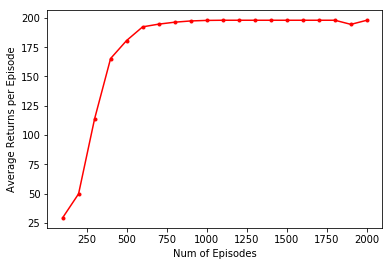

In [6]:
# plot average returns
returns_over_100_episodes = []
x = []
for i in range(0,int(num_episodes/100)):
    returns_over_100_episodes.append(sum(returns[100*i:100*(i+1)-1])/100)
    x.append((i+1)*100)
plt.plot(x,returns_over_100_episodes,'.-r')
plt.ylabel('Average Returns per Episode')
plt.xlabel('Num of Episodes')
plt.show()


In [19]:
# DEMO FINAL NETWORK


env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())
state = np.reshape(state, [1, state.size])
total_reward = 0
for i in range(0, 100000):
    env.render()
    action = DQN.net(Variable(FloatTensor([state[0]]), volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    
    # Take action, get new state and reward
    next_state, reward, done, _ = env.step(action[0][0])
    total_reward += reward

    if done:
        break
    else:
        state = np.reshape(next_state, [1, state.size])
